# Diagnosis of SS_GNN
* **Steps**: 
    * Import data ✅
    * Import Sampler ✅
    * Sample subgraphs from data. (args: k, m) ✅
    * Convert data to model input format
    * Import model ✅
    * Pass data through the model ✅
    * Investigate the subgraph distribution of intraclass
    * Investigate the subgraph distribution divergence of interclass
    * Dissect the model to investigate each component output
    * As we have seen earlier, the aggregation of subgraph encoding samples for
        the distinct classes are too close. How to make them distinct. Use some
        kind of normalization.

In [48]:
data_dim = 5
hidden_dim = 64

### Data (CSL)

In [49]:
import torch
import numpy as np
from torch_geometric.datasets import GNNBenchmarkDataset
from gps.utils.data_transform import SetNodeFeaturesOnes
from torch_geometric.loader import DataLoader

In [50]:
transform = SetNodeFeaturesOnes(dim=data_dim)
data = GNNBenchmarkDataset("./.temp/CSL", name='CSL', transform=transform)
loader = DataLoader(data,batch_size=1)
batch = next(iter(loader))

In [51]:
print(f'Single Graph[0]: {batch}')

Single Graph[0]: DataBatch(edge_index=[2, 164], y=[1], num_nodes=41, x=[41, 5], batch=[41], ptr=[2])


### Sampler

In [52]:
from uniform_sampler import sample_batch as sampler

In [53]:
k = 6
m = 100

In [54]:
nodes_sampled, edge_index_sampled, edge_ptr, sample_ptr, edge_src_global = sampler(batch.edge_index, batch.ptr, m_per_graph=m,k=k)

In [55]:
print(f'Nodes per graph: \n{nodes_sampled[:3].numpy()}\n ...\n {nodes_sampled[-3:].numpy()}\n\n'
    f'Edge index (sampled): \n{edge_index_sampled.numpy()} \n\n'
    f'Edge ptr (sample label edge boundary): \n{edge_ptr.numpy()}\n\n'
    f'Sample ptr (boundary ptr for each parent graph in sample nodes array): \n{sample_ptr.numpy()}\n\n'
    f'Edge src idx in original graph: \n{edge_src_global.numpy()}\n\n'
    f'Number of subgraphs: {nodes_sampled.shape[0]}')

Nodes per graph: 
[[23 24 26 28 30 31]
 [18 20 21 23 25 26]
 [23 24 26 27 29 30]]
 ...
 [[ 1 35 36 38 39 40]
 [14 15 16 18 20 21]
 [ 0 32 34 35 37 39]]

Edge index (sampled): 
[[0 1 1 ... 4 5 5]
 [1 0 2 ... 5 0 4]] 

Edge ptr (sample label edge boundary): 
[   0   10   20   30   42   56   68   84   96  106  122  134  144  156
  168  180  194  206  218  230  242  256  270  280  290  304  316  328
  340  352  362  378  392  404  414  424  434  444  458  468  480  492
  502  518  532  542  554  564  576  586  600  610  620  630  644  658
  668  684  696  708  722  734  752  766  776  786  798  808  818  828
  838  856  868  880  892  902  916  928  944  962  974  988 1002 1016
 1026 1036 1048 1062 1074 1086 1098 1112 1126 1138 1150 1160 1170 1180
 1192 1204 1214]

Sample ptr (boundary ptr for each parent graph in sample nodes array): 
[  0 100]

Edge src idx in original graph: 
[ 94  97  99 ... 151 156 157]

Number of subgraphs: 100


## View sampled subgraphs

In [56]:
import networkx as nx
import matplotlib.pyplot as plt

In [57]:
def plotsubgraphs(nodes_sampled, edge_index_sampled, edge_ptr, n=20):
    '''Plot subgraphs as subfigures. Choose subgraphs randomly and view with networkx and plt. Show graphs in clear untangled format
    so non-isomorphic graphs can be distinguished clearly. 
    Args:
        nodes_sampled: torch.Tensor of shape [num_total_subgraphs, k], nodes with indicies from parent graph. Each row is a subgraph.
        edge_index_sampled: torch.Tensor of shape [2, total_edges], source and target nodes indics are in {0,1,2,..,k-1}
        edge_ptr: torch.Tensor of shape [num_total_subgraphs+1], boundary indices from edges of each subgraph
        n: int number of subgraphs to show, randomly.
    '''
    num_subgraphs = nodes_sampled.shape[0]
    k = nodes_sampled.shape[1]
    
    # Randomly select n subgraphs to plot
    selected_indices = np.random.choice(num_subgraphs, size=min(n, num_subgraphs), replace=False)
    
    # Create subplots in a grid
    cols = 5
    rows = (len(selected_indices) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten() if rows * cols > 1 else [axes]
    
    for idx, subgraph_idx in enumerate(selected_indices):
        # Extract edges for this subgraph
        start_edge = edge_ptr[subgraph_idx].item()
        end_edge = edge_ptr[subgraph_idx + 1].item()
        
        # Get edge list for this subgraph
        edges = edge_index_sampled[:, start_edge:end_edge].T.numpy()
        
        # Create NetworkX graph
        G = nx.Graph()
        G.add_nodes_from(range(k))
        G.add_edges_from(edges)
        
        # Use spring layout for clear visualization
        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
        
        # Plot on the corresponding subplot
        ax = axes[idx]
        nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', 
                node_size=500, font_size=10, font_weight='bold', 
                edge_color='gray', width=2)
        
        # Get parent node indices for title
        parent_nodes = nodes_sampled[subgraph_idx].numpy()
        ax.set_title(f'Subgraph {subgraph_idx}\nNodes: {parent_nodes}', fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(selected_indices), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

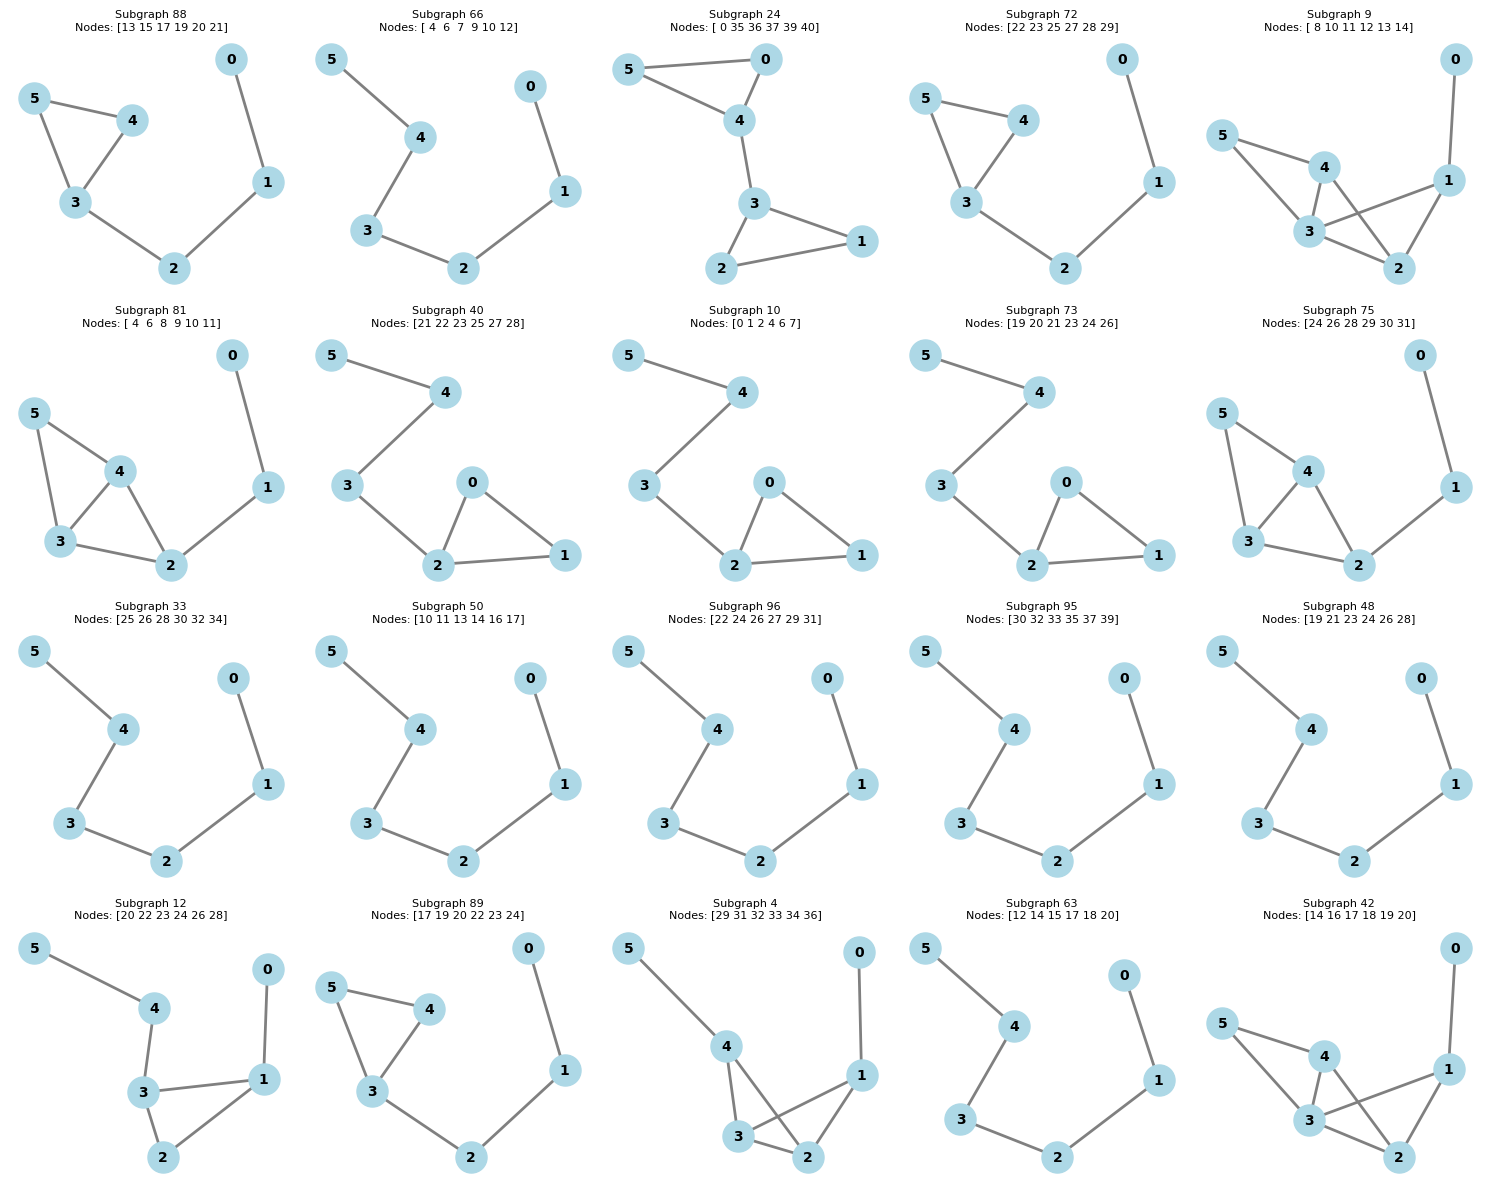

In [58]:
plotsubgraphs(nodes_sampled, edge_index_sampled, edge_ptr, n=20)

## Convert subgraph batch in to pyg-like format
* 1. stack nodes and get feature vector `x_global`.
  2. set all the failed node samples' (-1) feature vector to 0 vector. [ignored for now]
  3. convert edges from local node indics to global node indics.
  4. create a batch_ptr tensor of shape `[total_nodes, 1]`. for i-th node `batch_prt[i]` is the index of node's parent subgraph. 

In [20]:
num_subgraphs = nodes_sampled.shape[0]

In [21]:
x_global = batch.x[nodes_sampled.flatten()]

edge_index_global = torch.repeat_interleave(torch.arange(0,num_subgraphs), edge_ptr[1:]-edge_ptr[:-1])+edge_index_sampled

batch_ptr_global = torch.repeat_interleave(torch.arange(0,num_subgraphs),k)

In [22]:
print(f'feature for global nodes: \n{x_global.numpy()},\n\n edge_index in global node index: \n{edge_index_global.numpy()},\n\n batch_ptr: \n{batch_ptr_global.numpy()[:10]}...{batch_ptr_global.numpy()[-10:]}')

feature for global nodes: 
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]],

 edge_index in global node index: 
[[  0   1   1 ... 103 104 104]
 [  1   0   2 ... 104  99 103]],

 batch_ptr: 
[0 0 0 0 0 0 1 1 1 1]...[98 98 98 98 99 99 99 99 99 99]


In [30]:
# function to create ss-gnn input from dataset batch
def build_input(batch,k,m):
    nodes_sampled, edge_index_sampled, edge_ptr, sample_ptr, edge_src_global = \
        sampler(batch.edge_index, batch.ptr, m_per_graph=m,k=k)
    x_global = batch.x[nodes_sampled.flatten()]
    edge_index_global = torch.repeat_interleave(torch.arange(0,num_subgraphs), edge_ptr[1:]-edge_ptr[:-1])+edge_index_sampled
    batch_ptr_global = torch.repeat_interleave(torch.arange(0,num_subgraphs),k)
    return x_global, edge_index_global, batch_ptr_global

## SS-GNN Model
* subgraph encoder ['gnn', 'gcn', 'gin']
* aggr for subgraph encoding ['mean', 'sum', 'attention']
* graph level embeding [head]

In [24]:
from gps.models.ss_gnn import SubgraphGNNEncoder, SubgraphSamplingGNNClassifier

In [25]:
sample_encoder = SubgraphGNNEncoder(in_channels=data_dim,
                                    edge_dim = None,
                                    out_channels=hidden_dim, 
                                    hidden_dim=hidden_dim,
                                    conv_type='gcn',
                                    pooling='sum',
                                    batch_norm=False,
                                    res_connect=False)

In [31]:
encodings = []
for batch in loader:
    x, edg, ptr = build_input(batch,k,m)
    encodings.append(sample_encoder(x=x, edge_index=edg, batch=ptr))
    print(batch.y.item(), end=', ')

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [32]:
a = torch.unique(encodings[0],dim=0)[0]
b = torch.unique(encodings[0],dim=0)[1]
print(b-a)

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3842e-07,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -2.3842e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -2.3842e-07,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         5.9605e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       grad_fn=<SubBackward0>)


In [33]:
torch.unique(encodings[0], dim=0)

tensor([[  2.2691,  -5.1955,   5.2548,  -0.5573,   3.3421,   5.0780,  -3.9384,
           4.0705,  -0.7152,   1.4542,   1.4677,  -0.9306,  -3.8057,  -3.0133,
          -0.9083,  -1.4336,   0.4324,  -2.0078,   1.0388,  -4.0739,  -3.6171,
          -0.8516,  -0.6021,   4.1033,   4.1628,   2.8495,  -1.1758,  -1.1786,
           4.2333,  -0.0950,  -0.0888,  -2.2900,   3.9711,  -0.0914,  -0.0225,
          -8.0609,   4.3806,  -5.3368,   2.8747,  -1.6800,   1.4777,  -1.0776,
           3.8613,  -0.3714,   0.2671,  -0.6079,  -0.1660,   1.8810,  -0.3668,
           7.8773,   1.1749,  -1.8190,  -2.6781,  -9.4073,   4.6151,  -1.4165,
         -10.8595,   1.6522,   1.7906,  -2.0112,   3.8281,   3.1617,  -1.2166,
           4.1343],
        [  2.2691,  -5.1955,   5.2548,  -0.5573,   3.3421,   5.0780,  -3.9384,
           4.0705,  -0.7152,   1.4542,   1.4677,  -0.9306,  -3.8057,  -3.0133,
          -0.9083,  -1.4336,   0.4324,  -2.0078,   1.0388,  -4.0739,  -3.6171,
          -0.8516,  -0.6021,   4

## Diagnose SubgraphGNNEncoder Embedding Collapse

**Problem**: Even though sampled subgraphs are structurally different and 1-WL distinguishable, the SubgraphGNNEncoder produces identical embeddings.

**Hypotheses to test**:
1. All node features are identical (all-ones) → GCN cannot distinguish nodes
2. GCN with uniform features is not expressive enough
3. The 3-regular structure + uniform features creates symmetry
4. Batch normalization or pooling is causing collapse

In [61]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn.conv import GCNConv, GINConv
from torch_geometric.nn.pool import global_add_pool

### Create a Verbose model
    - layer 0: projection from datd in dim to model hidden dim
    - layer L1: GINConve
            - BatchNorm(optional)
            - Residual Connection(optional)
    - layer L2: GINConve
            - BatchNorm(optional)
            - Residual Connection(optional)    
            .
            .
            .
    - layer Ln: GINConve
            - BatchNorm(optional)
            - Residual Connection(optional)
    - layer Ln+1: add_pool_global
    - layer Ln+2: subgraph_aggrigation(mean_pool/sum_pool/attention)
    - layer Ln+3: classifier/regression/link_prediction

In [71]:
import torch_geometric.nn as pyg

In [85]:
class VerboseSubgraphEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers, pooling='sum', residual=False,batch_norm=False):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.batch_norm = batch_norm
        self.proj = nn.Linear(in_dim,hidden_dim,bias=False)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            neural_net = self._make_neural_net(in_dim=hidden_dim, out_dim=hidden_dim)
            self.convs.append(GINConv(neural_net,eps=0.1))
            if batch_norm:
                self.bns.append(pyg.BatchNorm(hidden_dim))
        if pooling == 'sum':
            self.pooling = pyg.global_add_pool
        self.activations = {}

    def forward(self, x, edge_index, batch):
        h = self.proj(x)
        self.activations['proj_0'] = h.clone()
        for l in range(self.num_layers):
            h_res = h
            h = self.convs[l](h,edge_index)
            self.activations[f'conv_{l}'] = h
            if self.batch_norm:
                h = self.bns[l](h)
                self.activations[f'bns_{l}'] = h
            if self.residual:
                h = h + h_res
                self.activations[f'res_{l}'] = h
        h_out = self.pooling(h,batch)
        self.activations['pooling'] = h_out
        return h_out
        
    def _make_neural_net(self, in_dim, out_dim, num_layers=2):
        layers = nn.ModuleList()
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers-1):
            layers.append(nn.Linear(out_dim, out_dim))
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)
        

In [87]:
encoder = VerboseSubgraphEncoder(in_dim = 5,hidden_dim=10,num_layers=4)

In [89]:
out = encoder(x_global, edge_index_global, batch_ptr_global)

In [140]:
x_global.shape

torch.Size([600, 5])

In [91]:
out.shape

torch.Size([100, 10])

In [95]:
activations = encoder.activations
for key in activations.keys():
    print(key,activations[key].shape)

proj_0 torch.Size([600, 10])
conv_0 torch.Size([600, 10])
conv_1 torch.Size([600, 10])
conv_2 torch.Size([600, 10])
conv_3 torch.Size([600, 10])
pooling torch.Size([100, 10])


In [96]:
proj_0 = activations['proj_0']
proj_dist = torch.cdist(proj_0,proj_0)

In [112]:
print(proj_dist[torch.any(proj_dist>0.0005, dim=1)])

tensor([], size=(0, 600), grad_fn=<IndexBackward0>)


All the nodes have same representation. So, pairwaise distances are zero.

In [122]:
conv_0 = activations['conv_0']
conv_0_dist = torch.cdist(conv_0, conv_0)
print(conv_0_dist[torch.any(conv_0_dist>0.0005,dim=0)])

tensor([[0.0000, 0.2883, 0.5767,  ..., 0.1445, 0.1445, 0.1445],
        [0.2883, 0.0000, 0.2883,  ..., 0.4288, 0.4288, 0.4288],
        [0.5767, 0.2883, 0.0000,  ..., 0.7163, 0.7163, 0.7163],
        ...,
        [0.1445, 0.4288, 0.7163,  ..., 0.0000, 0.0000, 0.0000],
        [0.1445, 0.4288, 0.7163,  ..., 0.0000, 0.0000, 0.0000],
        [0.1445, 0.4288, 0.7163,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<IndexBackward0>)


In [121]:
conv_1 = activations['conv_1']
conv_1_dist = torch.cdist(conv_1, conv_1)
print(conv_1_dist)

tensor([[0.0000, 0.4666, 1.0518,  ..., 0.1846, 0.1846, 0.1846],
        [0.4666, 0.0000, 0.5970,  ..., 0.6461, 0.6461, 0.6461],
        [1.0518, 0.5970, 0.0000,  ..., 1.2269, 1.2269, 1.2269],
        ...,
        [0.1846, 0.6461, 1.2269,  ..., 0.0000, 0.0000, 0.0000],
        [0.1846, 0.6461, 1.2269,  ..., 0.0000, 0.0000, 0.0000],
        [0.1846, 0.6461, 1.2269,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)


In [123]:
conv_2 = activations['conv_2']
conv_2_dist = torch.cdist(conv_2, conv_2)
print(conv_1_dist)

tensor([[0.0000, 0.4666, 1.0518,  ..., 0.1846, 0.1846, 0.1846],
        [0.4666, 0.0000, 0.5970,  ..., 0.6461, 0.6461, 0.6461],
        [1.0518, 0.5970, 0.0000,  ..., 1.2269, 1.2269, 1.2269],
        ...,
        [0.1846, 0.6461, 1.2269,  ..., 0.0000, 0.0000, 0.0000],
        [0.1846, 0.6461, 1.2269,  ..., 0.0000, 0.0000, 0.0000],
        [0.1846, 0.6461, 1.2269,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ViewBackward0>)


In [124]:
conv_3 = activations['conv_3']
conv_3_dist = torch.cdist(conv_3, conv_3)
print(conv_3_dist)

tensor([[0.0000e+00, 2.1647e-01, 1.1780e+00,  ..., 2.2605e-02, 2.2605e-02,
         2.2605e-02],
        [2.1647e-01, 0.0000e+00, 1.0104e+00,  ..., 2.3257e-01, 2.3257e-01,
         2.3257e-01],
        [1.1780e+00, 1.0104e+00, 4.8828e-04,  ..., 1.1844e+00, 1.1844e+00,
         1.1844e+00],
        ...,
        [2.2605e-02, 2.3257e-01, 1.1844e+00,  ..., 1.7263e-04, 1.7263e-04,
         1.7263e-04],
        [2.2605e-02, 2.3257e-01, 1.1844e+00,  ..., 1.7263e-04, 1.7263e-04,
         1.7263e-04],
        [2.2605e-02, 2.3257e-01, 1.1844e+00,  ..., 1.7263e-04, 1.7263e-04,
         1.7263e-04]], grad_fn=<ViewBackward0>)


In [129]:
pooling = activations['pooling']
pooling_dist = torch.cdist(pooling, pooling)
print(pooling_dist)

tensor([[1.1049e-02, 7.1481e+01, 5.4125e+01,  ..., 2.8427e+01, 2.8427e+01,
         2.8427e+01],
        [7.1481e+01, 0.0000e+00, 1.7356e+01,  ..., 9.9879e+01, 9.9879e+01,
         9.9879e+01],
        [5.4125e+01, 1.7356e+01, 0.0000e+00,  ..., 8.2528e+01, 8.2528e+01,
         8.2528e+01],
        ...,
        [2.8427e+01, 9.9879e+01, 8.2528e+01,  ..., 4.8828e-04, 4.8828e-04,
         4.8828e-04],
        [2.8427e+01, 9.9879e+01, 8.2528e+01,  ..., 4.8828e-04, 4.8828e-04,
         4.8828e-04],
        [2.8427e+01, 9.9879e+01, 8.2528e+01,  ..., 4.8828e-04, 4.8828e-04,
         4.8828e-04]], grad_fn=<ViewBackward0>)


**Findings**: 
* after few message passing the distinct graphs starts to be different. 
even for few pairs of subgraphs, which should have same node embedding,
due to message passing mechanism, have non-zero distance becouse of GIN $\epsilon$.
* after pooling different subgraphs have different embeddings
* *so distinct subgraphs have always different embeddings*

## Verbose Attention
Now we observe the embedding distances of different graphs with different labels. 
So we know that it can distinguish graphs from different classes. 
We also need to check if the graphs of same classes have similar embeddings.
Atleas same graph produces similar very embeddings for two different sampling. By that I mean the sampling induced noise should be minimum. 

In [141]:
from torch_geometric.utils import scatter

In [145]:
class AttentionAggregator(nn.Module):
    def __init__(self, hidden_dim, temperature=0.2, pooling='sum'):
        super().__init__()
        self.temperature = temperature
        self.attention_mlp = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim//2),
        nn.ReLU(),
        nn.Linear(hidden_dim//2,1)
            )
        def forward(self, subgraph_embeddings, batch):
            num_graphs = batch.max().item()+1
            scores = self.attention_mlp(subgraph_embedding)
            scores = scores/self.temperature

            # find the max score along all subgraphs of each graph of the batch
            max_scores = scatter(scores, batch, dim=0, dim_size=num_graphs, reduce='max')
            # assign the corresponding max score to each subgraph of the batch
            max_scores = max_scores[batch]
            # e^{-(max_scores-scores)}
            scores_exp = torch.exp(scores-max_scores)
            # sum exp scores along each graph
            scores_sum = scatter(scores_exp, batch, dim=0, dim_size=num_graphs, reduce='sum')
            # boadcast socres_sums along each subgraph
            scores_sum = scores_sum[batch]
            # normalizing the scores_exp
            attention_weights = scores_exp / (scores_sum + 1e-8)
            
            '''scaling subgraph embeddings with sttention_weights
                attention_weights should prioritize significant subgraphs
                and scalling with attention weight should enhance (increase
                in magnitude) the important subgraph embeddings. 
            '''
            weighted_embeddings = attention_weights * subgraph_embeddings
            # finally, weighted sum for all subgraphs of each graph
            graphs_embeddings = scatter(weighted_embeddings, batch, dim=0, dim_size=num_graphs, reduce='sum')
            return graphs_embeddings

## Data loding again for new run
Observe the distribution through out the model pipeline. Starting from data ending at graph level representation. 
Measure the differences between emperical statistics and true distributions. 